In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#from bokeh.plotting import figure, show, output_notebook
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

plt.style.use("ggplot") # Set plot style
%matplotlib inline

# **Importing the dataset**

In [2]:
df = pd.read_csv(r"./hourly-energy-consumption/PJME_hourly.csv")

In [3]:
df["Datetime"] = pd.to_datetime(df["Datetime"])

#Date features
df["Hour"] = df["Datetime"].dt.hour
df["Day"] = df["Datetime"].dt.dayofweek
df["Month"] = df["Datetime"].dt.month
df["Year"] = df["Datetime"].dt.year
df["Q"] = df["Datetime"].dt.quarter
df["Dayofyear"] = df["Datetime"].dt.dayofyear
df["Dayofmonth"] = df["Datetime"].dt.day
df["Weekofyear"] = df["Datetime"].dt.weekofyear

df["Drop_me"] = df["Datetime"].dt.strftime("%m-%d")

df.index = df["Datetime"]
df = df.drop(["Datetime"],axis=1)

In [4]:
df.head()

,PJME_MW,Hour,Day,Month,Year,Q,Dayofyear,Dayofmonth,Weekofyear,Drop_me
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,2002,4,365,31,1,12-31
2002-12-31 02:00:00,25147.0,2,1,12,2002,4,365,31,1,12-31
2002-12-31 03:00:00,24574.0,3,1,12,2002,4,365,31,1,12-31
2002-12-31 04:00:00,24393.0,4,1,12,2002,4,365,31,1,12-31
2002-12-31 05:00:00,24860.0,5,1,12,2002,4,365,31,1,12-31


Text(0.0, 1.0, 'Consumption distribution')

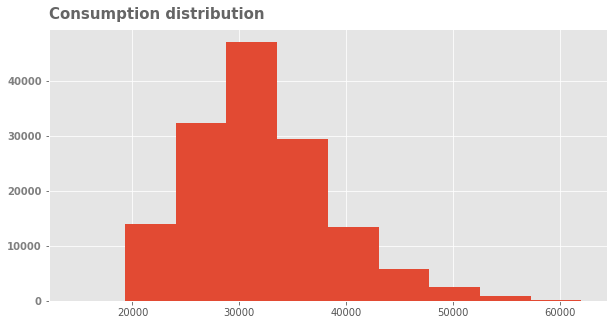

In [5]:
ax, fig = plt.subplots(figsize=(10,5))

plt.hist(df["PJME_MW"])

plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("",alpha=0.75, weight="bold")
plt.ylabel("",alpha=0.75, weight="bold")

plt.title("Consumption distribution", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

The distribution plot is slightly left-skewed, with the majority of the consumption moving around the 30-35k range.

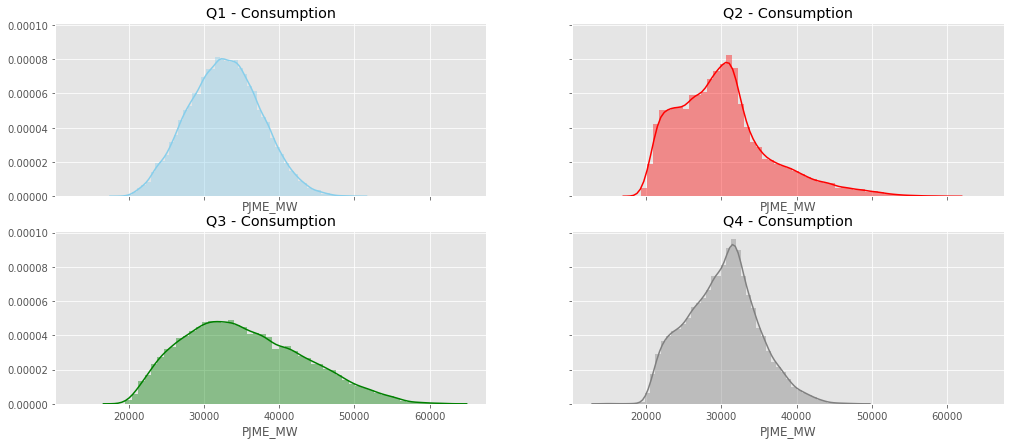

In [6]:
#Data prep
Q1 = df[df["Q"]==1]
Q2 = df[df["Q"]==2]
Q3 = df[df["Q"]==3]
Q4 = df[df["Q"]==4]

#Plot
fig,axes = plt.subplots(2,2,figsize=(17,7),sharex=True,sharey=True)

sns.distplot(Q1["PJME_MW"],color="skyblue", ax=axes[0,0]).set_title("Q1 - Consumption")
sns.distplot(Q2["PJME_MW"],color="red", ax=axes[0,1]).set_title("Q2 - Consumption")
sns.distplot(Q3["PJME_MW"],color="green", ax=axes[1,0]).set_title("Q3 - Consumption")
sns.distplot(Q4["PJME_MW"],color="gray", ax=axes[1,1]).set_title("Q4 - Consumption")

del Q1, Q2, Q3, Q4

Text(0.0, 1.0, 'Mean daily consumption')

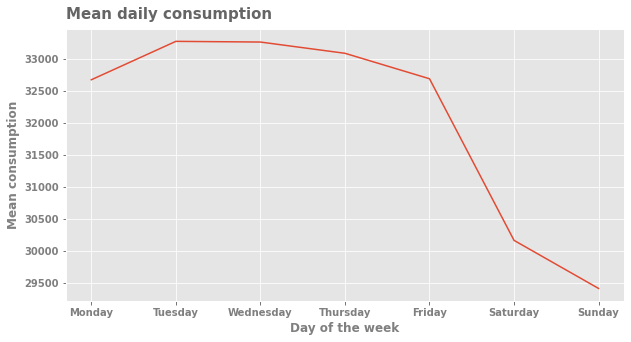

In [8]:
mean_per_day = df.groupby("Day")["PJME_MW"].agg(["mean"])

fig, ax = plt.subplots(figsize=(10,5))


plt.plot(mean_per_day.index,mean_per_day["mean"])

plt.xticks(mean_per_day.index, ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"], alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Day of the week",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")

plt.title("Mean daily consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

#del mean_per_day

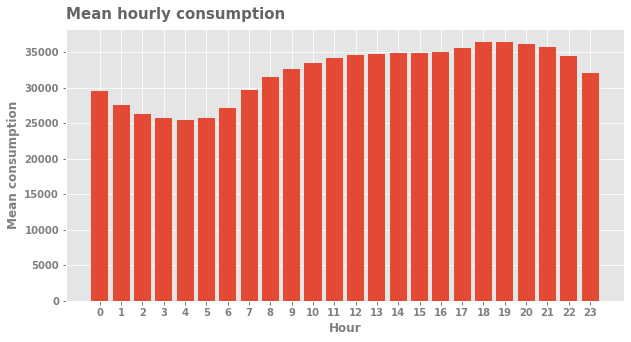

In [9]:
mean_per_hour = df.groupby("Hour")["PJME_MW"].agg(["mean"])

fig, ax = plt.subplots(figsize=(10,5))

plt.bar(mean_per_hour.index, mean_per_hour["mean"])

plt.xticks(range(24),alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Hour",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")

plt.title("Mean hourly consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

del mean_per_hour

Text(0.0, 1.0, 'Consumption over time')

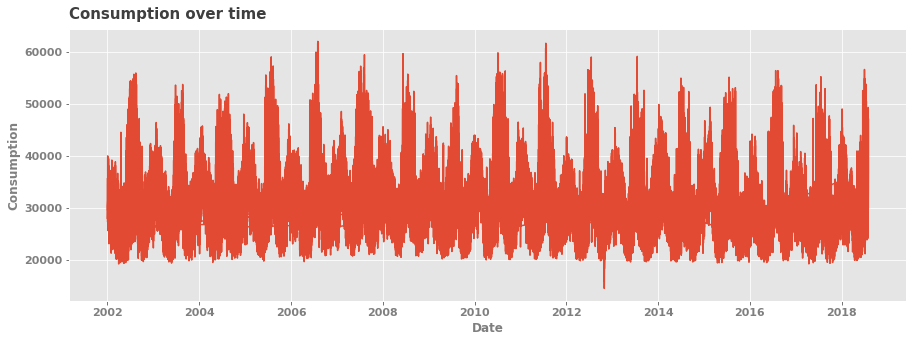

In [10]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(df.index,df["PJME_MW"])

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Consumption over time", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [11]:
def feature_holidays(row):

    if row["Drop_me"] == "01-01":
        return "New Year"
    if row["Drop_me"] == "04-07":
        return "Ind Day"
    if row["Drop_me"] == "11-28":
        return "Thanksgiving"
    if row["Drop_me"] == "12-25":
        return "Christmas"
    return 'Other'
def feature_worktime(row):
    if row["Hour"] > 7 & row["Hour"] <= 17:
        return "Worktime"
    return "NonWorkTime"
def feature_peak(row):
    if row["Hour"] > 7 & row["Hour"] <= 22:
        return "Peak"
    return "NonPeak"
def feature_weekend(row):
    if row["Day"] == 5 or row["Day"] == 6:
        return "Weekend"
    return "NonWeekend"

In [12]:
df["Holiday"] = df.apply (lambda row : feature_holidays(row), axis=1)
df["Work"] = df.apply(lambda row: feature_worktime(row), axis=1)
df["Peak"] = df.apply(lambda row: feature_peak(row), axis=1)
df["Weekend"] = df.apply(lambda row: feature_weekend(row), axis=1)

In [13]:
df = df.drop(["Drop_me"],axis=1)

In [14]:
dummies = pd.get_dummies(df[["Holiday","Peak","Work","Weekend"]],prefix="Dummy")
df = df.join(dummies,lsuffix="_left")
df = df.drop(df[["Holiday","Peak","Work","Weekend"]], axis=1)

In [15]:
train_test_date = "01-01-2015"
consum_test = df[df.index > train_test_date].copy()
consum_train = df[df.index <= train_test_date].copy()

In [16]:
def lag_features(lag_dataset,period_list):

    temp_data = lag_dataset["PJME_MW"]

    for period in period_list:

        lag_dataset["lag_consumption_{}".format(period)] = temp_data.shift(period)
        lag_dataset["mean_rolling_{}".format(period)] = temp_data.rolling(period).mean()
        lag_dataset["max_rolling_{}".format(period)] = temp_data.rolling(period).max()
        lag_dataset["min_rolling_{}".format(period)] = temp_data.rolling(period).min()

    for column in lag_dataset.columns[20:]:

        lag_dataset[column] = lag_dataset[column].fillna(lag_dataset.groupby("Hour")["PJME_MW"].transform("mean"))
    
    return lag_dataset

In [17]:
consum_train = lag_features(consum_train,[7,14,30])

consum_test = lag_features(consum_test,[7,14,30])

Text(0.0, 1.0, 'Train - Test Split')

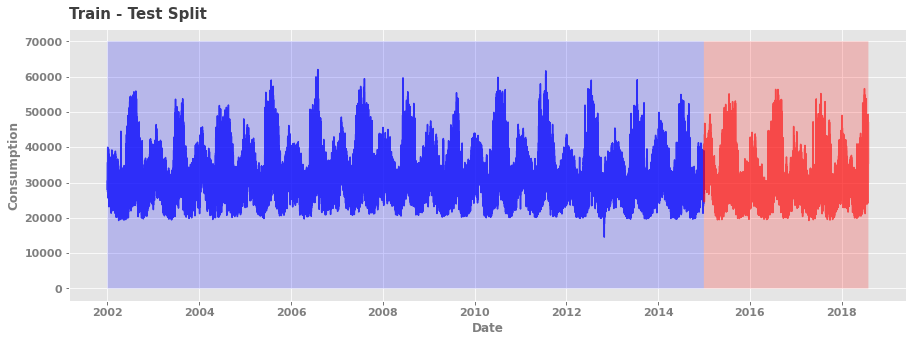

In [18]:
fig,ax = plt.subplots(figsize=(15,5))

coloring = 70000

plt.plot(consum_train.index,consum_train["PJME_MW"],color="blue", alpha=0.75)
plt.fill_between(consum_train.index,coloring, facecolor="blue", alpha=0.2)

plt.plot(consum_test.index,consum_test["PJME_MW"], color = "red", alpha=0.60)
plt.fill_between(consum_test.index,coloring, facecolor="red", alpha=0.2)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Train - Test Split", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [19]:
X_train = consum_train.drop("PJME_MW", axis=1) 
y_train = consum_train["PJME_MW"]
X_test = consum_test.drop("PJME_MW", axis=1)
y_test = consum_test["PJME_MW"]

In [20]:
xgd_reg = xgb.XGBRegressor(n_estimators=1000)

xgd_reg.fit(X_train,y_train,
           eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=50,
           verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

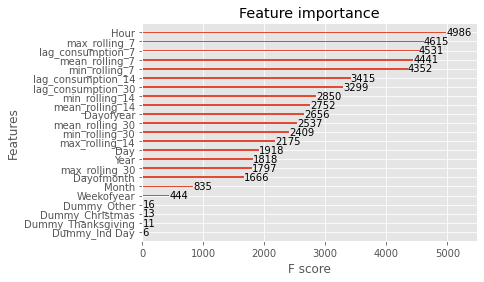

In [21]:
plot_importance(xgd_reg)

In [22]:
consum_test["Prediction"] = xgd_reg.predict(X_test)

Text(0.0, 1.0, 'Predicted consumption')

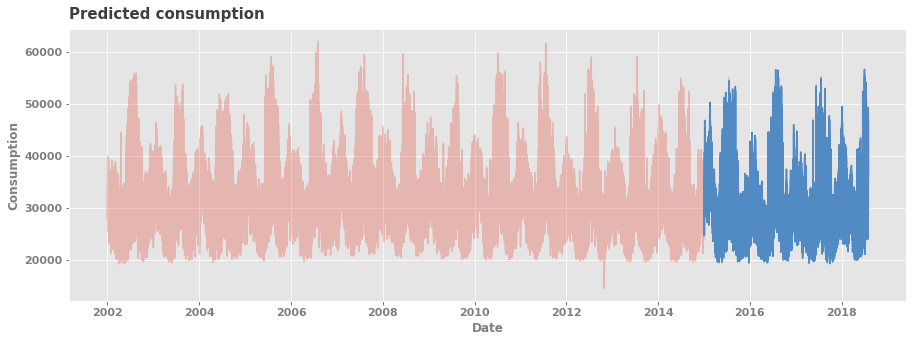

In [23]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(consum_train.index,consum_train["PJME_MW"],alpha=.3)
plt.plot(consum_test.index,consum_test["Prediction"])
plt.plot(consum_test.index,consum_test["PJME_MW"],alpha=.3)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Predicted consumption", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

Text(0.0, 1.0, 'Predicted consumption')

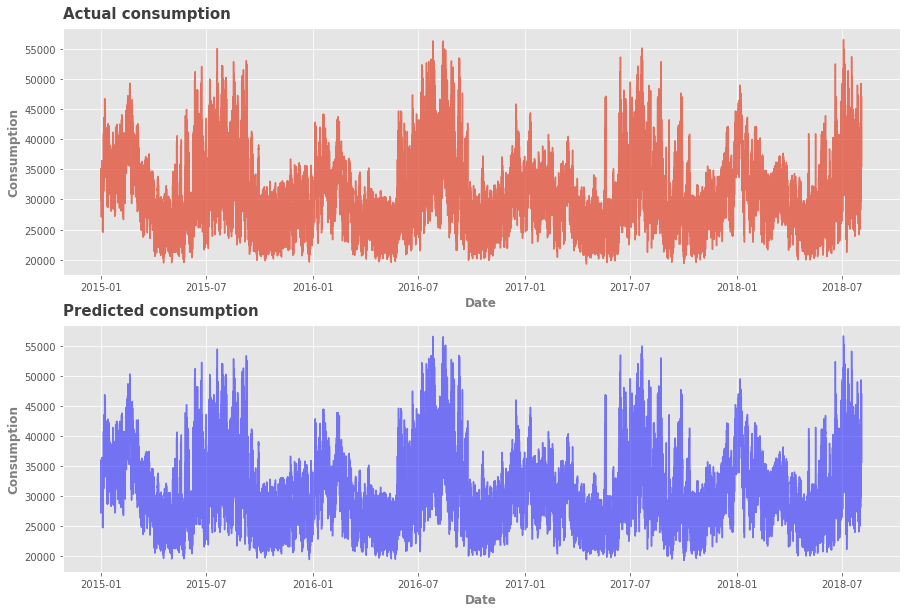

In [24]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10),sharey=True)

ax1.plot(consum_test.index,consum_test["PJME_MW"],alpha=0.75)
ax2.plot(consum_test.index,consum_test["Prediction"],color="blue",alpha=0.50)

ax1.set_xlabel("Date", alpha=0.75, weight="bold")
ax1.set_ylabel("Consumption", alpha=0.75, weight="bold")
ax2.set_xlabel("Date", alpha=0.75, weight="bold")
ax2.set_ylabel("Consumption", alpha=0.75, weight="bold")

ax1.set_title("Actual consumption", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
ax2.set_title("Predicted consumption", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [25]:
mean_sq = mean_squared_error(y_test,xgd_reg.predict(X_test))
rmse = np.sqrt(mean_sq)

mean_abs_sq = mean_absolute_error(y_test,xgd_reg.predict(X_test))

print("Root Mean Squared Error : {}".format(rmse))
print("Mean Absolute Error : {}".format(mean_abs_sq))

Root Mean Squared Error : 444.0139849775216
Mean Absolute Error : 266.8715374811178


In [26]:
consum_test["Difference"] = np.abs(consum_test["PJME_MW"] - consum_test["Prediction"])
consum_test["Difference"].sort_values(ascending=False)[:10]

Datetime
2016-07-18 18:00:00    4605.203125
2018-07-17 17:00:00    4591.453125
2018-01-04 12:00:00    3950.640625
2016-01-28 13:00:00    3842.757812
2015-02-20 15:00:00    3837.882812
2018-07-17 16:00:00    3642.886719
2018-02-27 12:00:00    3498.863281
2017-06-19 18:00:00    3348.457031
2018-03-26 13:00:00    3261.832031
2017-03-23 13:00:00    3226.292969
Name: Difference, dtype: float64

ConversionError: Failed to convert value(s) to axis units: '2017-03-12 00:00:00'

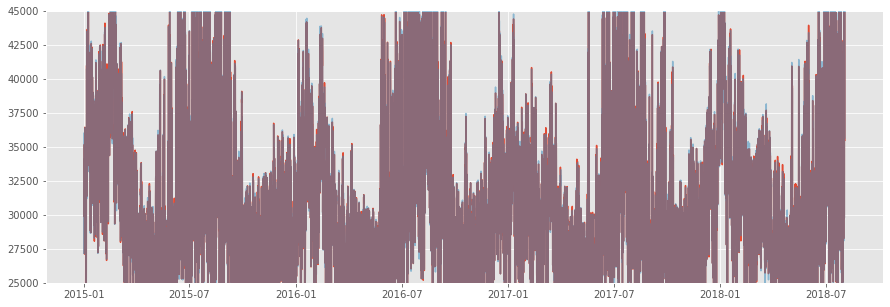

In [27]:
fig,ax= plt.subplots(figsize=(15,5))


ax.plot(consum_test.index,consum_test["PJME_MW"],label="Actual")
ax.plot(consum_test.index,consum_test["Prediction"],alpha=.5,zorder=10,label="Predicted")

consum = consum_test["PJME_MW"]
pred = consum_test["Prediction"]

plt.fill_between(consum_test.index, consum,pred, facecolor="green", alpha=.2,label="Difference")

ax.set_ylim(25000, 45000)
ax.set_xbound(lower="2017-03-12 00:00:00", upper="2017-03-12 23:30:00")

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Period with the worst hourly prediction", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
plt.legend()

In [28]:
worst_days = consum_test.groupby(['Year','Month','Dayofmonth']).mean()[['PJME_MW','Prediction','Difference']]
worst_days.sort_values(by="Difference",ascending=False)[:10]

,,,PJME_MW,Prediction,Difference
Year,Month,Dayofmonth,,,
2015,2,20,44694.041667,45281.195312,1324.858724
2017,12,31,39016.000000,37755.890625,1260.108236
2015,1,1,31720.521739,30937.273438,1023.471722
2016,2,15,39439.416667,39082.367188,896.493001
2018,1,4,41065.000000,40287.203125,888.428548
2015,2,16,43949.500000,43683.980469,873.082845
2017,3,13,34010.000000,34297.308594,871.637370
2015,2,24,41002.166667,41499.746094,844.351237
2017,3,23,32248.208333,32968.609375,833.064453


ConversionError: Failed to convert value(s) to axis units: '2016-02-20'

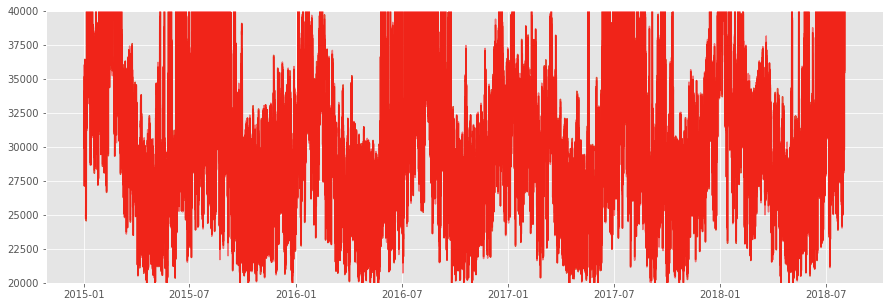

In [29]:
fig,ax= plt.subplots(figsize=(15,5))


ax.plot(consum_test.index,consum_test["PJME_MW"],label="Actual")
ax.plot(consum_test.index,consum_test["Prediction"],color="red",alpha=.5,zorder=10,label="Predicted")

consum = consum_test["PJME_MW"]
pred = consum_test["Prediction"]

plt.fill_between(consum_test.index, consum,pred, facecolor="green", alpha=.2,label="Difference")

ax.set_ylim(20000, 40000)
ax.set_xbound(lower="2016-02-20", upper="2016-02-25")

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Period with the worst daily prediction", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

plt.legend()

In [30]:
worst_days.sort_values(by="Difference",ascending=True)[:10]

PJME_MW    Prediction  Difference
Year Month Dayofmonth                                        
2016 5     24          27713.375000  27701.412109   52.251628
2015 10    7           27375.041667  27357.816406   58.544352
2016 10    13          26975.125000  27002.304688   62.789795
           2           24659.083333  24686.769531   66.911947
2015 10    14          26942.000000  26968.425781   72.897054
2016 10    1           24848.416667  24869.015625   73.257080
     5     19          26437.708333  26420.925781   73.484375
2015 6     3           27229.000000  27215.322266   74.142578
     4     30          26311.375000  26322.085938   75.792969
     10    6           27123.541667  27104.617188   77.880941

ConversionError: Failed to convert value(s) to axis units: '2015-10-28'

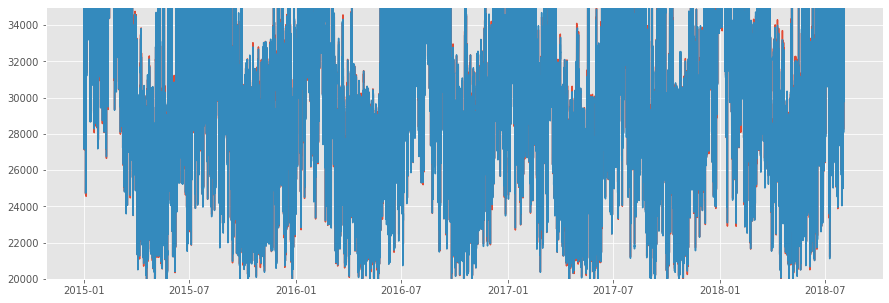

In [31]:
fig,ax= plt.subplots(figsize=(15,5))

ax.plot(consum_test.index,consum_test["PJME_MW"], label="Actual")
ax.plot(consum_test.index,consum_test["Prediction"], label="Predicted")
consum = consum_test["PJME_MW"]
pred = consum_test["Prediction"]

plt.fill_between(consum_test.index, consum,pred, facecolor="green", alpha=.2,label="Difference")

ax.set_ylim(20000, 35000)
ax.set_xbound(lower="2015-10-28", upper="2015-10-30")

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Period with the best daily prediction", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")


plt.legend()